In [1]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Model, GPT2ForSequenceClassification, Trainer, TrainingArguments
import torch
import json
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from tqdm import tqdm
import random

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Setup the Transformer

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('gpt2', pad_token_id=tokenizer.eos_token_id)
model.eval().cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

# GPT-2 Utility functions

In [4]:
def generate(prompt, max_length=21, stop_token=None):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    generated_text_ids = model.generate(input_ids=input_ids.cuda(), max_length=max_length+len(input_ids[0]), do_sample=False)
    generated_text = tokenizer.decode(generated_text_ids[0], clean_up_tokenization_spaces=True)
    post_prompt_text = generated_text[len(tokenizer.decode(input_ids[0], clean_up_tokenization_spaces=True)):]
    return prompt + post_prompt_text[:post_prompt_text.find(stop_token) if stop_token else None]

In [5]:
# Note that the logits are shifted over 1 to the left, since HuggingFace doesn't give a logit for the first token
def get_logits_and_tokens(text):
    input_ids = tokenizer.encode(text, return_tensors="pt")
    tokens = [tokenizer.decode([input_id]) for input_id in input_ids[0]]
    output = model(input_ids.cuda())
    return output.logits[0][:-1], tokens

# Loading the data

In [6]:
def load_jsonl(filename):
    f = open(filename)
    return [json.loads(line) for line in f.read().splitlines()]

In [7]:
train_examples = load_jsonl("data/train.jsonl")
dev_examples = load_jsonl("data/dev.jsonl")
test_examples = load_jsonl("data/test_no_labels.jsonl")

In [8]:
def split_neg_pos_examples(examples):
    pos_examples, neg_examples = [],[]
    for eg in examples:
        if eg['label'] == 'True':
            pos_examples.append(eg)
        else:
            neg_examples.append(eg)
    return pos_examples, neg_examples

In [9]:
def text_size_plot(examples):
    length = []
    for eg in examples:
        length.append(len(eg['text']))
    n = [i for i in range(len(examples))]
    plt.bar(n, length)
    print("Smallest 10 samples : "+str(sorted(length)[:10]))

Splitting the data into negative and positive samples in order to create a balanced training set

In [10]:
pos_examples, neg_examples = split_neg_pos_examples(train_examples)

Checking out the distribution of the length of the texts in the training samples. Because gpt2 takes max 1024 tokens as input, we can only input a few of the training samples for the prompt

Smallest 10 samples : [558, 575, 727, 730, 731, 808, 812, 821, 828, 842]


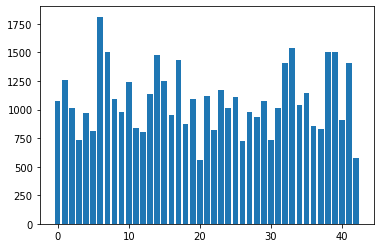

In [11]:
text_size_plot(pos_examples)

Smallest 10 samples : [166, 171, 177, 216, 218, 224, 225, 251, 251, 254]


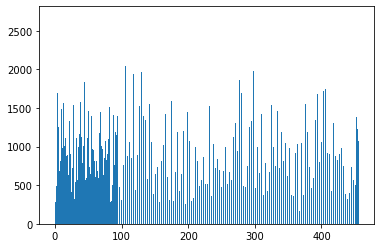

In [12]:
text_size_plot(neg_examples)

Sorting the training examples in order of the length of the texts in order to incorporate more samples in the prompt as much as possible

In [13]:
train_examples = sorted(train_examples,key=lambda x:len(x['text']))
pos_examples, neg_examples = split_neg_pos_examples(train_examples)

# Basic prompt building

In [14]:
def render_example(example):
    title = example["text"].split(".")[0].strip()
    abstract = example["text"][len(title)+1:].strip()
    return f"""Title: {title}
Abstract: {abstract}
Label: {"AI" if example["label"] == "True" else "Not AI"}"""

In [15]:
def render_end_example(example):
    title = example["text"].split(".")[0].strip()
    abstract = example["text"][len(title)+1:].strip()
    return f"""Title: {title}
Abstract: {abstract}
Label:"""

In [16]:
def make_prompt(instructions, train_examples, end_example):
    rendered_train_examples = "\n\n--\n\n".join([render_example(example) for example in train_examples])
    return f"""{instructions}

{rendered_train_examples}

--

{render_end_example(end_example)}"""

Function to create prompts for all the examples in the training set in order to get a classification for each of the examples of the dataset

In [17]:
def make_prompts(instructions, train_examples, end_examples):
    rendered_train_examples = "\n\n--\n\n".join([render_example(example) for example in train_examples])
    
    prompts = []
    for end_example in end_examples:
        prompts.append( f"""{instructions}

{rendered_train_examples}

--

{render_end_example(end_example)}""" )
        
    return prompts

Generic function to classify all the examples using prompt generated using a few examples

In [18]:
def classify_gpt(train_examples, end_examples, INSTRUCTIONS):

    prompts = make_prompts(INSTRUCTIONS, train_examples, end_examples)
    outputs = []

    for prompt in tqdm(prompts):
        generated_text = generate(prompt, stop_token="\n")
        output = generated_text.split('\n')[-1][7:]
        outputs.append(output)
        
    return outputs

### Due to imbalanced dataset, we look at the precision, recall and f1 score other than accuracy

In [19]:
def print_metrics(outputs, examples):
    pred = torch.Tensor([0 if out=='Not AI' else 1 for out in outputs])
    label = torch.Tensor([0 if out['label']=='False' else 1 for out in examples])
    accuracy = (label==pred).sum() / len(label)
    ConfusionMatrixDisplay.from_predictions(label, pred, display_labels=['Not AI','AI'])
    plt.show()
    report = classification_report(label, pred, target_names=['Not AI','AI'])
    return accuracy, report

In [20]:
def train_dev_accuracy(prompt_examples, train_examples, dev_examples, INSTRUCTIONS):
    
    print("-------------Train Set-------------")
    train_outputs = classify_gpt(prompt_examples,train_examples,INSTRUCTIONS)
    train_accuracy, train_report = print_metrics(train_outputs, train_examples)
    print("Train Set accuracy = {}".format(str(train_accuracy)))
    print(train_report)
    dev_outputs = classify_gpt(prompt_examples,dev_examples,INSTRUCTIONS)
    dev_accuracy, dev_report = print_metrics(dev_outputs, dev_examples)
    print("-------------Dev Set-------------")
    print("Dev Set accuracy = {}".format(str(dev_accuracy)))
    print(dev_report)
    

## Classification using the straightforward way

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

-------------Train Set-------------


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:09<00:00,  3.86it/s]


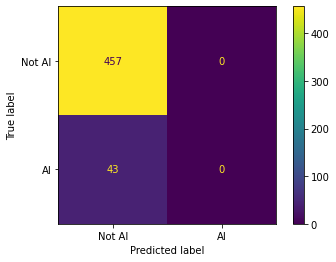

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

Train Set accuracy = tensor(0.9140)
              precision    recall  f1-score   support

      Not AI       0.91      1.00      0.96       457
          AI       0.00      0.00      0.00        43

    accuracy                           0.91       500
   macro avg       0.46      0.50      0.48       500
weighted avg       0.84      0.91      0.87       500



100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:12<00:00,  3.77it/s]


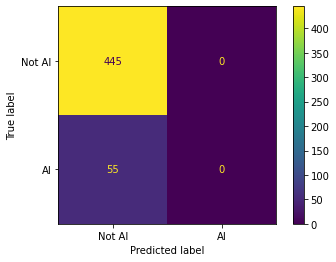

-------------Dev Set-------------
Dev Set accuracy = tensor(0.8900)
              precision    recall  f1-score   support

      Not AI       0.89      1.00      0.94       445
          AI       0.00      0.00      0.00        55

    accuracy                           0.89       500
   macro avg       0.45      0.50      0.47       500
weighted avg       0.79      0.89      0.84       500



In [21]:
INSTRUCTIONS = "Classify the following examples based on whether they are AI-relevant or not:"
train_dev_accuracy(train_examples[:7],train_examples,dev_examples,INSTRUCTIONS)

#### From the result, we can see that the model classifies default 'Not AI' for all the examples. This is due to imbalanced dataset, so the training examples in the prompt only contains example of one class

## Prompt Engineering

generic function to look at the generated text as well look at the probabilites of the 2 classes as output by the pretrained model

In [22]:
def check_prob_gentext(INSTRUCTIONS, train_examples, end_example):
    
    prompt = make_prompt(INSTRUCTIONS, train_examples, end_example)

    generated_text = generate(prompt, stop_token="\n")

    #print(generated_text)

    logits, tokens = get_logits_and_tokens(generated_text)
    last_token_probs = torch.softmax(logits[-1], dim=0)
    negative_prob = last_token_probs[tokenizer.encode(" AI")[0]]
    positive_prob = last_token_probs[tokenizer.encode(" Not AI")[0]]

    print(f"Not AI prob: {negative_prob}\nAI prob: {positive_prob}")

In [23]:
INSTRUCTIONS = "Classify each of the following examples based on whether they are AI-relevant or not"
check_prob_gentext(INSTRUCTIONS, train_examples[:4], train_examples[4])

Not AI prob: 0.9934048056602478
AI prob: 1.0336410923628137e-05


## Classification using the balanced dataset of positive and negative samples

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

-------------Train Set-------------


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:18<00:00,  3.62it/s]


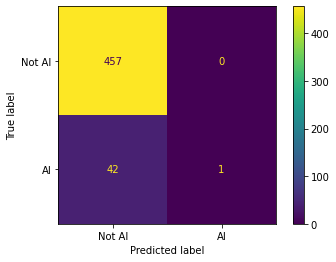

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

Train Set accuracy = tensor(0.9160)
              precision    recall  f1-score   support

      Not AI       0.92      1.00      0.96       457
          AI       1.00      0.02      0.05        43

    accuracy                           0.92       500
   macro avg       0.96      0.51      0.50       500
weighted avg       0.92      0.92      0.88       500



100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:17<00:00,  3.63it/s]


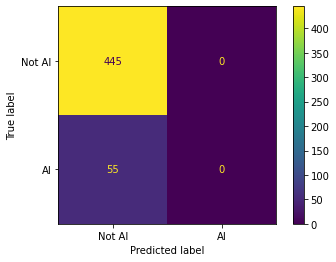

-------------Dev Set-------------
Dev Set accuracy = tensor(0.8900)
              precision    recall  f1-score   support

      Not AI       0.89      1.00      0.94       445
          AI       0.00      0.00      0.00        55

    accuracy                           0.89       500
   macro avg       0.45      0.50      0.47       500
weighted avg       0.79      0.89      0.84       500



In [24]:
train_dev_accuracy(pos_examples[:2]+neg_examples[:2],train_examples,dev_examples,INSTRUCTIONS)

#### Based on the results, the result is only insignificantly improved. This means that we need to engineer better prompts for training

Changing the 'label' to 'AI-related' and changing the instruction so that the model answers True or False to whether the text is related to AI

In [25]:
def render_example(example):
    title = example["text"].split(".")[0].strip()
    abstract = example["text"][len(title)+1:].strip()
    return f"""Title: {title}
Abstract: {abstract}
AI-relevant: {"True" if example["label"] == "True" else "False"}"""

In [26]:
def render_end_example(example):
    title = example["text"].split(".")[0].strip()
    abstract = example["text"][len(title)+1:].strip()
    return f"""Title: {title}
Abstract: {abstract}
AI-relevant:"""

In [27]:
def check_prob_gentext(INSTRUCTIONS, train_examples, end_example):
    
    prompt = make_prompt(INSTRUCTIONS, train_examples, end_example)

    generated_text = generate(prompt, stop_token="\n")

    print(generated_text)

    logits, tokens = get_logits_and_tokens(generated_text)
    last_token_probs = torch.softmax(logits[-1], dim=0)
    negative_prob = last_token_probs[tokenizer.encode(" False")[0]]
    positive_prob = last_token_probs[tokenizer.encode(" True")[0]]

    print(f"\n\nTrue prob: {positive_prob}\nFalse prob: {negative_prob}")

In [28]:
INSTRUCTIONS = "Classify each of the following examples based on whether they are AI-relevant or not"
check_prob_gentext(INSTRUCTIONS, train_examples[:10], pos_examples[16])

Classify each of the following examples based on whether they are AI-relevant or not

Title: acoustic lens associated with a radial oscillating bubble
Abstract: in this paper we show that a radial oscillating bubble in a liquid behaves like a convergent acoustic lens.
AI-relevant: False

--

Title: diophantine approximations and the convergence of certain series
Abstract: consider two series theta < alpha leq theta in mathbb q theta theta alpha> frac12 theta theta alpha leq .
AI-relevant: False

--

Title: ancient multiple layer solutions to the allen cahn equation
Abstract: we consider the parabolic one dimensional allen cahn equation w x = tanh x sqrt u k k w t to infty xi j t gamma jk .
AI-relevant: False

--

Title: searches for new neutral gauge bosons and leptoquarks at the tevatron
Abstract: this contribution reports on some of the most recent searches for new heavy neutral bosons and leptoquarks performed at the tevatron experiments.
AI-relevant: False

--

Title: some remarks 

In [29]:
INSTRUCTIONS = "Classify each of the following examples based on whether they are AI-relevant or not"
check_prob_gentext(INSTRUCTIONS, pos_examples[:4]+neg_examples[:4], pos_examples[16])

Classify each of the following examples based on whether they are AI-relevant or not

Title: horn a system for parallel training and regularizing of large scale neural networks
Abstract: i introduce a new distributed system for effective training and regularizing of large scale neural networks on distributed computing architectures. the experiments demonstrate the effectiveness of flexible model partitioning and parallelization strategies based on neuron centric computation model with an implementation of the collective and parallel dropout neural networks training. experiments are performed on mnist handwritten digits classification including results.
AI-relevant: True

--

Title: image completion on cifar
Abstract: . this project performed image completion on cifar a dataset of 32x32 rgb images using three different neural network architectures fully convolutional networks convolutional networks with fully connected layers and encoder decoder convolutional networks. the highest perfo

#### Performs better for balanced dataset. But still looking at the probabilities, the model is still confused about the result

Better mixing the samples together, so there is no repeatable pattern that can be considered by the model

In [30]:
INSTRUCTIONS = "Classify each of the following examples based on whether they are AI-relevant or not"
training_examples = []
for i in range(4):
    if torch.randint(2,(1,)):
        training_examples.append(pos_examples[i])
        training_examples.append(neg_examples[i])
    else:
        training_examples.append(neg_examples[i])
        training_examples.append(pos_examples[i])
check_prob_gentext(INSTRUCTIONS, training_examples, neg_examples[16])

Classify each of the following examples based on whether they are AI-relevant or not

Title: horn a system for parallel training and regularizing of large scale neural networks
Abstract: i introduce a new distributed system for effective training and regularizing of large scale neural networks on distributed computing architectures. the experiments demonstrate the effectiveness of flexible model partitioning and parallelization strategies based on neuron centric computation model with an implementation of the collective and parallel dropout neural networks training. experiments are performed on mnist handwritten digits classification including results.
AI-relevant: True

--

Title: acoustic lens associated with a radial oscillating bubble
Abstract: in this paper we show that a radial oscillating bubble in a liquid behaves like a convergent acoustic lens.
AI-relevant: False

--

Title: diophantine approximations and the convergence of certain series
Abstract: consider two series theta <

#### Better result than without mixing.

Considering another instruction

In [31]:
INSTRUCTIONS = "For each of the following examples, output Yes if they are related to Artificial Intelligence(AI) else No"
training_examples = []
for i in range(4):
    if torch.randint(2,(1,)):
        training_examples.append(pos_examples[i])
        training_examples.append(neg_examples[i])
    else:
        training_examples.append(neg_examples[i])
        training_examples.append(pos_examples[i])
check_prob_gentext(INSTRUCTIONS, training_examples, neg_examples[16])

For each of the following examples, output Yes if they are related to Artificial Intelligence else No

Title: acoustic lens associated with a radial oscillating bubble
Abstract: in this paper we show that a radial oscillating bubble in a liquid behaves like a convergent acoustic lens.
AI-relevant: False

--

Title: horn a system for parallel training and regularizing of large scale neural networks
Abstract: i introduce a new distributed system for effective training and regularizing of large scale neural networks on distributed computing architectures. the experiments demonstrate the effectiveness of flexible model partitioning and parallelization strategies based on neuron centric computation model with an implementation of the collective and parallel dropout neural networks training. experiments are performed on mnist handwritten digits classification including results.
AI-relevant: True

--

Title: image completion on cifar
Abstract: . this project performed image completion on cifa

#### The probabilities are still too close but the output 

In [32]:
def classify_gpt(train_examples, end_examples, INSTRUCTIONS):

    prompts = make_prompts(INSTRUCTIONS, train_examples, end_examples)
    outputs = []

    for prompt in tqdm(prompts):
        generated_text = generate(prompt, stop_token="\n")
        output = generated_text.split('\n')[-1][13:]
        outputs.append(output)
        
    return outputs

In [33]:
def print_metrics(outputs, examples):
    pred = torch.Tensor([0 if out=='False' else 1 for out in outputs])
    label = torch.Tensor([0 if out['label']=='False' else 1 for out in examples])
    accuracy = (label==pred).sum() / len(label)
    ConfusionMatrixDisplay.from_predictions(label, pred, display_labels=['Not AI','AI'])
    plt.show()
    report = classification_report(label, pred, target_names=['Not AI','AI'])
    return accuracy, report

In [34]:
training_examples = []
for i in range(2):
    if torch.randint(2,(1,)):
        training_examples.append(pos_examples[i])
        training_examples.append(neg_examples[i])
    else:
        training_examples.append(neg_examples[i])
        training_examples.append(pos_examples[i])

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

-------------Train Set-------------


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:14<00:00,  3.72it/s]


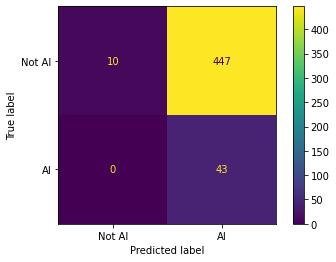

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

Train Set accuracy = tensor(0.1060)
              precision    recall  f1-score   support

      Not AI       1.00      0.02      0.04       457
          AI       0.09      1.00      0.16        43

    accuracy                           0.11       500
   macro avg       0.54      0.51      0.10       500
weighted avg       0.92      0.11      0.05       500



100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:10<00:00,  3.84it/s]


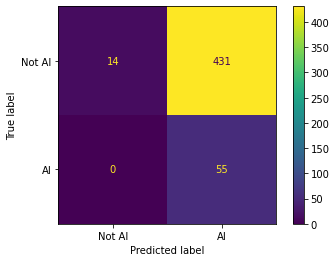

-------------Dev Set-------------
Dev Set accuracy = tensor(0.1380)
              precision    recall  f1-score   support

      Not AI       1.00      0.03      0.06       445
          AI       0.11      1.00      0.20        55

    accuracy                           0.14       500
   macro avg       0.56      0.52      0.13       500
weighted avg       0.90      0.14      0.08       500



In [35]:
INSTRUCTIONS = "For each of the following examples, output Yes if they are related to Artificial Intelligence(AI) else No"
train_dev_accuracy(training_examples,train_examples,dev_examples,INSTRUCTIONS)

#### Result is poor but atleast the model is thinking about the different labels and no default output like previously

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

-------------Train Set-------------


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:15<00:00,  3.69it/s]


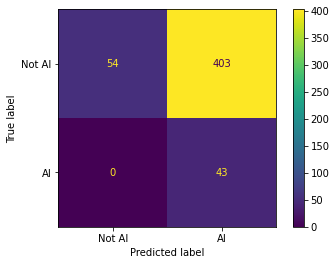

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

Train Set accuracy = tensor(0.1940)
              precision    recall  f1-score   support

      Not AI       1.00      0.12      0.21       457
          AI       0.10      1.00      0.18        43

    accuracy                           0.19       500
   macro avg       0.55      0.56      0.19       500
weighted avg       0.92      0.19      0.21       500



100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:19<00:00,  3.58it/s]


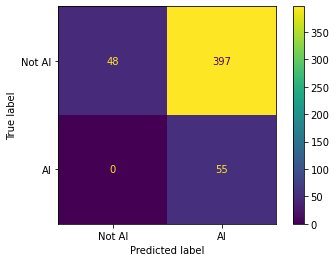

-------------Dev Set-------------
Dev Set accuracy = tensor(0.2060)
              precision    recall  f1-score   support

      Not AI       1.00      0.11      0.19       445
          AI       0.12      1.00      0.22        55

    accuracy                           0.21       500
   macro avg       0.56      0.55      0.21       500
weighted avg       0.90      0.21      0.20       500



In [38]:
training_examples = pos_examples[:2] + neg_examples[:3]
INSTRUCTIONS = "For each of the following examples, output Yes if the abstract is related to Artificial Intelligence(AI) else No"
train_dev_accuracy(training_examples,train_examples,dev_examples,INSTRUCTIONS)

#### Slightly better output but classification biased towards positive classification

Adding an extra negative sample as its length is less and would fit the model

In [37]:
training_examples = []
for i in range(2):
    if torch.randint(2,(1,)):
        training_examples.append(pos_examples[i])
        training_examples.append(neg_examples[i])
    else:
        training_examples.append(neg_examples[i])
        training_examples.append(pos_examples[i])
training_examples.append(neg_examples[2])    

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

-------------Train Set-------------


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:14<00:00,  3.72it/s]


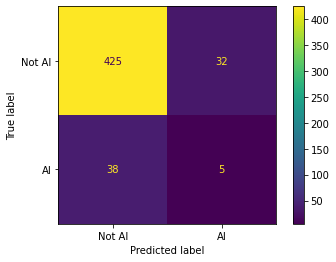

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

Train Set accuracy = tensor(0.8600)
              precision    recall  f1-score   support

      Not AI       0.92      0.93      0.92       457
          AI       0.14      0.12      0.12        43

    accuracy                           0.86       500
   macro avg       0.53      0.52      0.52       500
weighted avg       0.85      0.86      0.86       500



100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:20<00:00,  3.56it/s]


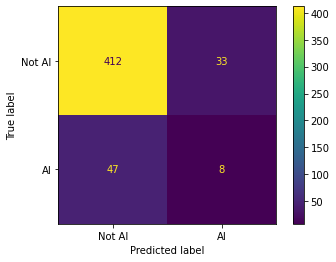

-------------Dev Set-------------
Dev Set accuracy = tensor(0.8400)
              precision    recall  f1-score   support

      Not AI       0.90      0.93      0.91       445
          AI       0.20      0.15      0.17        55

    accuracy                           0.84       500
   macro avg       0.55      0.54      0.54       500
weighted avg       0.82      0.84      0.83       500



In [36]:
INSTRUCTIONS = "For each of the following examples, output Yes if the abstract is related to Artificial Intelligence(AI) else No"
train_dev_accuracy(training_examples,train_examples,dev_examples,INSTRUCTIONS)

#### Best output so far but still classification biased toward False value

## Classification using the title only

In [36]:
def render_example(example):
    title = example["text"].split(".")[0].strip()
    return f"""Title: {title}
AI-relevant: {"True" if example["label"] == "True" else "False"}"""

In [37]:
def render_end_example(example):
    title = example["text"].split(".")[0].strip()
    return f"""Title: {title}
AI-relevant:"""

In [38]:
training_examples = []
for i in range(10):
    if torch.randint(2,(1,)):
        training_examples.append(pos_examples[i])
        training_examples.append(neg_examples[i])
    else:
        training_examples.append(neg_examples[i])
        training_examples.append(pos_examples[i])

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

-------------Train Set-------------


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:07<00:00,  3.93it/s]


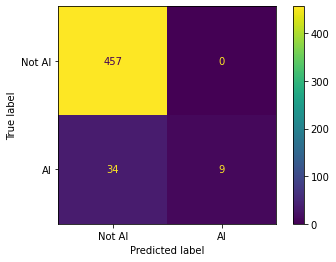

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

Train Set accuracy = tensor(0.9320)
              precision    recall  f1-score   support

      Not AI       0.93      1.00      0.96       457
          AI       1.00      0.21      0.35        43

    accuracy                           0.93       500
   macro avg       0.97      0.60      0.66       500
weighted avg       0.94      0.93      0.91       500



100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:09<00:00,  3.86it/s]


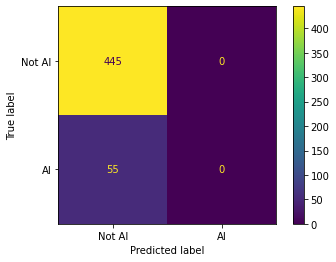

-------------Dev Set-------------
Dev Set accuracy = tensor(0.8900)
              precision    recall  f1-score   support

      Not AI       0.89      1.00      0.94       445
          AI       0.00      0.00      0.00        55

    accuracy                           0.89       500
   macro avg       0.45      0.50      0.47       500
weighted avg       0.79      0.89      0.84       500



In [39]:
INSTRUCTIONS = "For each of the following examples, output Yes if the title is related to Artificial Intelligence(AI) else No"
train_dev_accuracy(training_examples,train_examples,dev_examples,INSTRUCTIONS)

#### Using just the titles did not help. Abstract must be taken into account

### References
####  https://arxiv.org/abs/2005.14165
#### https://huggingface.co/docs/transformers/model_doc/gpt2